#### **Author: Wissem Khlifi**

# 03 - Vertex AI > Pipelines - AutoML automated pipeline

Use[ Kubeflow](https://www.kubeflow.org/) Pipelines running on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) to orchestrate the process of training a custom model with AutoML Tabular and deploy it to a Vertex AI Endpoint for serving (online and batch) predictions and explanations.  
### Prerequisites:
-  01 -  BigQuery - Table Data Source

### [HomeWork] Resources:
-  [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/build-pipeline#google-cloud-components) see aiplatform.PipelineJob
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [Kubeflow Pipelines Components for Google Cloud](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud)

### [HomeWork] Related Training:
-  Codelab: [Vertex AI Pipelines Introduction](https://codelabs.developers.google.com/vertex-mlmd-pipelines#0)


## Setup

### Inputs:

In [1]:
# Get the GCP project ID from the gcloud configuration
# This ensures the notebook uses the correct GCP project for all operations.

project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'genai-demo-2024'

In [2]:
# Set the region for GCP services
# Specifying the region is necessary for certain GCP services to function correctly.
REGION = 'us-central1'

# Define source data parameters
# These variables specify the BigQuery dataset and table to be used.
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'ml_datasets'
BQ_TABLE = 'ulb_fraud_detection'

# Define the notebook identifier
# This helps in organizing and tracking different notebooks.
NOTEBOOK = '03'

# Resources
# Specify the compute resources to be used for model training and deployment.
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
# Define the target variable for the model and any variables to omit from the training data.
# Model Training
# Define the target variable for the model and any variables to omit from the training data.
# 'transaction_id' is omitted because it is a unique identifier for each transaction and does not provide useful information 
# for the model to learn patterns or relationships. Including such unique identifiers can lead to overfitting where the model 
# memorizes the IDs instead of learning generalizable features. 

# 'Feedback' is omitted because it may not be directly relevant to the prediction task or it may contain information 
# that is not useful for the model. Including irrelevant features can introduce noise and reduce the model's performance.

# 'service_account_email' is omitted because it is likely the same value for all records in the dataset, 
# providing no variance for the model to learn from. Features with the same value across all records do not contribute 
# to the learning process and can be safely excluded.

VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id Feedback service_account_email' # add more variables to the string with space delimiters

### Packages:

In [6]:
# Install necessary pipeline components if not already installed
# This line can be skipped if already done in a previous notebook (00).
#!pip install -U google-cloud-pipeline-components -U -q

In [5]:
# Import necessary libraries for creating and managing AI pipelines

from google.cloud import aiplatform # For interacting with Google Cloud Vertex AI 
from datetime import datetime # For handling date and time operations
import kfp # Kubeflow Pipelines SDK
from kfp import compiler # For compiling pipeline components
#import kfp.v2.dsl as dsl
#import google_cloud_pipeline_components as gcc_aip # Vertex platform pipeline components
from google_cloud_pipeline_components.v1.dataset import TabularDatasetCreateOp  # For custom Python package training jobs
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp # For custom container training jobs
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp # For creating endpoints & For deploying models

from google.cloud import bigquery # For interacting with BigQuery
from google.protobuf import json_format # For handling JSON and protobuf 
from google.protobuf.struct_pb2 import Value  # For creating protobuf values
import json # For general JSON operations
import numpy as np # For numerical operations

### Clients:

In [7]:
# Initialize Vertex AI Platform and BigQuery clients
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client() # Initialize BigQuery client

### Parameters:

In [8]:
# Define parameters for the pipeline execution

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S") # Current timestamp for naming and organizing outputs
BUCKET = PROJECT_ID # The GCP project ID, used here as the bucket name
URI = f"gs://{BUCKET}/{BQ_TABLE}/models/{NOTEBOOK}" # GCS URI for saving models
DIR = f"temp/{NOTEBOOK}" # Local directory for temporary storage

In [9]:
# Retrieve the service account email from the gcloud configuration
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)'  # Run gcloud command to get the service account email
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0] # Extract the service account email from the command output
SERVICE_ACCOUNT

'292219499736-compute@developer.gserviceaccount.com'

### List the service accounts current roles:

In [10]:
# Run gcloud command to list roles of the service account
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/aiplatform.admin
roles/aiplatform.notebookRuntimeAdmin
roles/aiplatform.user
roles/artifactregistry.admin
roles/bigquery.admin
roles/cloudbuild.builds.editor
roles/cloudfunctions.admin
roles/cloudscheduler.admin
roles/dataproc.worker
roles/dialogflow.client
roles/dialogflow.reader
roles/iam.serviceAccountAdmin
roles/iam.serviceAccountUser
roles/logging.admin
roles/ml.admin
roles/notebooks.runner
roles/pubsub.admin
roles/resourcemanager.projectIamAdmin
roles/run.admin
roles/secretmanager.admin
roles/serviceusage.serviceUsageAdmin
roles/serviceusage.serviceUsageConsumer
roles/storage.admin
roles/storage.objectAdmin


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [11]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Pipeline (KFP) Definition
- Flow
    - Create Vertex AI Dataset from link to BigQuery table
    - Create Vertex AI AutoML Tabular Training Job
    - Create Endpoint and Depoy trained model
    
Use [AI Platform Pipeline Components](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/)
- Specifically, [AutoMLTabularTrainingJobRunOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.AutoMLTabularTrainingJobRunOp)

Define a Job:
- Consider Weighting :  Adjusts for class imbalance by assigning weights to classes
- Model Type : : Specifies the type of model (e.g., classification, regression)
- Optimization Objective : Defines the metric to optimize (e.g., AUC for binary classification)

In [12]:
@kfp.dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-{BQ_TABLE}-{TIMESTAMP}', # Name of the pipeline
    pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/' # Root URI for pipeline artifacts
)
def pipeline(
    project: str,
    dataname: str,
    display_name: str,
    deploy_machine: str,
    bq_source: str,
    var_target: str,
    var_omit: str,
    features: dict,
    labels: dict 
):
    
    # Step to create a Vertex AI Dataset from BigQuery table
    #  Creates a Vertex AI Dataset from a BigQuery table.
    dataset = TabularDatasetCreateOp(
        project = project,# GCP project ID
        display_name = display_name, # Display name for the dataset
        bq_source = bq_source, # BigQuery table source
        labels = labels # Labels for the dataset
    )
    
   # Step to run an AutoML Tabular Training Job
   # Runs an AutoML Tabular Training Job.
    model = AutoMLTabularTrainingJobRunOp(
        project = project, # GCP project ID
        display_name = display_name, # Display name for the training job
        optimization_prediction_type = "classification", # Model type
        optimization_objective = "maximize-au-prc", # Optimization objective
        budget_milli_node_hours = 1000, # Training budget in milli node hours
        disable_early_stopping=False, # Disable early stopping
        column_specs = features, # Feature specifications
        dataset = dataset.outputs['dataset'], # Input dataset
        target_column = var_target, # Target variable for the model
        predefined_split_column_name = 'splits', # Column name for predefined splits
        labels = labels # Labels for the training job
    )
    
    # Step to create an endpoint and deploy the trained model
    endpoint = EndpointCreateOp(
        project = project, # GCP project ID
        display_name = display_name, # Display name for the endpoint
        labels = labels # Labels for the endpoint
    )
    
    # Endpoint: Deployment of Model
    deployment = ModelDeployOp(
        model = model.outputs["model"], # Trained model
        endpoint = endpoint.outputs["endpoint"], # Endpoint to deploy the model
        dedicated_resources_min_replica_count = 1, # Minimum number of replicas
        dedicated_resources_max_replica_count = 1, # Maximum number of replicas
        traffic_split = {"0": 100}, # Percentage of traffic to be directed to the mode
        dedicated_resources_machine_type= deploy_machine # Machine type for the endpoint
    )

#### Explanation of Training Budget in Milli Node Hours :
In Vertex AI, the training budget is specified in milli node hours. This parameter controls the amount of computational resources allocated for the training job. Here’s a detailed explanation:
 - What are Node Hours?  A node hour represents one hour of computation on a single node (or machine) in the cloud. The node type (e.g., standard, high-memory, or high-CPU) determines the compute power of each node.
- Milli Node Hours : This unit allows finer control over the budget. One milli node hour is one-thousandth of a node hour.
- 1 Node Hour = 1,000 Milli Node Hours : This means you can specify smaller increments of compute time, providing more flexibility in managing costs and resources.
- Why Use Milli Node Hours? Cost Management : Using milli node hours helps in accurately controlling the budget for the training job. You can allocate just the right amount of resources needed without over-provisioning.


---
## Compile Pipeline

In [13]:
# Compile the pipeline to a JSON file
# The compiled pipeline is stored in a specified directory for execution.

compiler.Compiler().compile(
    pipeline_func = pipeline, # The pipeline function to be compiled
    package_path = f"{DIR}/{NOTEBOOK}.json"  # The path where the compiled JSON file will be saved
)

#### Move compiled pipeline files to GCS Bucket

In [14]:
# Copy the compiled pipeline JSON file to Google Cloud Storage (GCS)
# This allows the pipeline to be accessed and executed by Vertex AI.

!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/03/03.json [Content-Type=application/json]...
/ [1 files][ 46.6 KiB/ 46.6 KiB]                                                
Operation completed over 1 objects/46.6 KiB.                                     


---
## Create Vertex AI Pipeline Job

Get features dictionary for the pipeline input:

In [15]:
# Get feature names from the BigQuery table schema
# This step retrieves the schema of the table to identify which columns will be used as features.
# Define the query to fetch column names from the BigQuery table schema
query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{BQ_TABLE}_prepped'"
# Execute the query and convert the result to a DataFrame
schema = bq.query(query).to_dataframe()
# Filter out columns to be omitted from the features list
OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
# Convert the list of features to a dictionary format required by the pipeline
features = dict.fromkeys(features, 'auto')
# Display the query used for debugging purposes
query


"SELECT * FROM genai-demo-2024.ml_datasets.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'ulb_fraud_detection_prepped'"

#####  Run The pipeline:

In [16]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}', # Display name for the pipeline job
    template_path = f"{URI}/{TIMESTAMP}/kfp/{NOTEBOOK}.json", # Path to the compiled pipeline JSON file in GCS
    parameter_values = {
        "project" : PROJECT_ID,
        "dataname" : BQ_TABLE,
        "display_name" : f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
        "deploy_machine" : DEPLOY_COMPUTE,
        "bq_source" : f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
        "var_target" : VAR_TARGET,
        "var_omit" : VAR_OMIT,
        "features" : features,
        "labels" : {'notebook': NOTEBOOK}       
    }, # Dictionary of parameters to pass to the pipeline
    labels = {'notebook': NOTEBOOK},
    enable_caching=False
)

In [17]:
# Run the pipeline job
# this job would take +2 hours,  depending on your infrastcuture
response = pipeline.run(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240527124725-20240527130427
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240527124725-20240527130427')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-03-ulb-fraud-detection-20240527124725-20240527130427?project=292219499736
PipelineJob projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240527124725-20240527130427 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240527124725-20240527130427 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detecti

## **For the remaining commands in the notebook: Since the pipeline job takes a significant amount of time to complete, we will demonstrate the results of the following commands on stage.**


Visual Representation of the pipeline can be viewed in the console:

In [ ]:
# Review the Pipeline as it runs here:
print(f"Review the Pipeline as it runs here:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/pipelines/runs/{pipeline.resource_name.split('/')[-1]}?project={PROJECT_ID}")

In [19]:
# Print the pipeline details

print(pipeline)
print(f'kfp-{NOTEBOOK}-{BQ_TABLE}-{TIMESTAMP}')

resource name: projects/292219499736/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240527124725-20240527130427
kfp-03-ulb_fraud_detection-20240527124725


## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

##### Get the Model:

In [22]:
# Retrieve the model trained using AutoML
models = aiplatform.Model.list(filter=f'labels.notebook={NOTEBOOK}')

In [23]:
model = models[0]
model.resource_name

'projects/292219499736/locations/us-central1/models/3777518432270942208'

Retrives the aggregate model evalution metrics for the model as a whole.  

Either:
- First, use `model.list_model_evaluations()` to retrieve the evaluation id, then use `model.get_model_evaluation(evaluation_id = )` for the evaluation id
- Or, use `.get_model_evaluation()` and it will retrieve the first model evaluation

In [24]:
# Retrieve the aggregate model evaluation metrics for the model as a whole
evaluation = model.get_model_evaluation().to_dict() # get first evaluation

In [25]:
# View model evaluation
evaluation.keys()

dict_keys(['name', 'metricsSchemaUri', 'metrics', 'createTime', 'sliceDimensions', 'modelExplanation'])

In [26]:
# Key metrics to observe
evaluation['metrics'].keys()

dict_keys(['auPrc', 'auRoc', 'logLoss', 'confusionMatrix', 'confidenceMetrics'])

In [27]:
# Accessing detailed metrics including confidence metrics
evaluation['metrics']['confidenceMetrics'][3]

{'falseNegativeCount': '4',
 'recallAt1': 0.99971586,
 'falsePositiveRateAt1': 0.00028416154,
 'truePositiveCount': '28149',
 'recall': 0.9998579,
 'trueNegativeCount': '28111',
 'confidenceThreshold': 0.01,
 'falsePositiveRate': 0.0014918481,
 'precisionAt1': 0.99971586,
 'confusionMatrix': {'rows': [[28132.0, 1.0, 0.0],
   [7.0, 13.0, 0.0],
   [0.0, 0.0, 0.0]],
  'annotationSpecs': [{'displayName': '0', 'id': '0'},
   {'displayName': '1', 'id': '1'},
   {'displayName': 'DROPPED', 'id': 'DROPPED'}]},
 'precision': 0.9985102,
 'f1ScoreAt1': 0.99971586,
 'f1ScoreMacro': 0.7710177,
 'f1Score': 0.9991836,
 'falsePositiveCount': '42',
 'f1ScoreMicro': 0.9991836}

Review several of the metrics included in the evaluation.  Also, compare these to the results in the console view.

In [28]:
print(f"Review this model in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/evaluations/{evaluation['name'].split('/')[-1]}?project={PROJECT_ID}")

Review this model in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/3777518432270942208/versions/1/evaluations/6835074947119957086?project=genai-demo-2024


In [29]:
# AUC-PR value
evaluation['metrics']['auPrc']

0.9998602

##### - **Interpretation of the Results**:
**Example : (Your results could be different)**

An AUC-PR value of `0.9998602` indicates an excellent model performance. The closer the value is to `1.0`, the better the model is at distinguishing between the positive and negative classes.

In [30]:
# Access and print the confusion matrix
# Print the confusion matrix, which shows how often each class is predicted correctly versus incorrectly.

for i in range(len(evaluation['metrics']['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', evaluation['metrics']['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', evaluation['metrics']['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28132.0, 1.0, 0.0]
True Label =  1  has Predicted labels =  [7.0, 13.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model as well using the .gapic api version:

##### - **Interpretation**:
  - **True Label = 0**: Shows the breakdown of predictions for instances that are truly negative. , `28,132` were correctly predicted as `0`, and `1` was incorrectly predicted as `1`.
  - **True Label = 1**: Shows the breakdown of predictions for instances that are truly positive. `7` were incorrectly predicted as `0`, and `13` were correctly predicted as `1`.
  - **True Label = DROPPED**: Indicates no instances were labeled as "DROPPED". (No instances were actually labeled as "DROPPED", indicating that this label was not present or was excluded.)

This confusion matrix shows that the model has a high number of true positives and true negatives, indicating good predictive performance, especially in distinguishing the negative class

In [31]:
# Retrieving and Printing Evaluation Slices
# Create a model client to interact with the model evaluation API
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [32]:
# List model evaluation slices
# Slices can be used to evaluate model performance on different subsets of the data

slices = model_client.list_model_evaluation_slices(parent = evaluation['name'])

In [33]:
# Iterate through each slice and print its metrics
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.9998931
Label =  1 has auPrc =  0.7696064


##### - **Interpretation of the Results**: 
**Example : (Your results could be different)**
  - **Label = 1 (Positive Class)**: The AUC-PR for the positive class is `0.7696064`, indicating good but not perfect performance in predicting the positive class.
  - **Label = 0 (Negative Class)**: The AUC-PR for the negative class is `0.9998931`, indicating excellent performance in predicting the negative class.


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [34]:
# Execute the query and convert the result to a DataFrame

pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, splits, transaction_id, Feedback)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped
        WHERE splits='TEST'
        LIMIT 10
    """
).to_dataframe()

In [35]:
# Display the first few rows of the prediction data
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,service_account_email
0,66341.0,-1.975549,-1.606799,0.081444,-2.159326,0.589567,0.334022,0.091121,0.745302,-1.320319,...,0.071180,-0.009378,0.598930,-0.905916,-0.817125,1.139974,-0.061121,-0.101225,200.5,292219499736-compute@developer.gserviceaccount...
1,138794.0,1.556636,-0.858618,-1.541472,1.235769,0.142803,0.172018,0.186438,-0.093988,0.434570,...,0.536618,1.219162,-0.459225,-0.981304,0.427739,-0.227500,-0.026433,-0.027460,250.0,292219499736-compute@developer.gserviceaccount...
2,100922.0,1.923291,-0.511650,0.217122,0.583403,-1.043504,-0.428347,-0.946888,-0.055398,2.688932,...,-0.104106,0.033558,0.299543,-0.059774,-0.628523,0.441857,-0.045307,-0.039834,39.0,292219499736-compute@developer.gserviceaccount...
3,151295.0,-2.663683,2.410267,-0.956647,-1.124388,-0.477937,-0.984630,0.318403,0.709386,1.257919,...,0.003444,0.682532,-0.168789,-0.016866,0.370005,0.166635,0.867921,0.614288,20.0,292219499736-compute@developer.gserviceaccount...


In [36]:
# Prepare Data for Prediction
# Convert the 'Time' column to numeric to ensure proper format
# The `Time` column is converted to numeric to ensure all data is in the correct format for prediction. 
# The DataFrame is then converted to a dictionary format (`records` orientation) which is required by the prediction API.

import pandas as pd
pred['Time'] = pd.to_numeric(pred['Time'], errors='coerce')

# Convert the DataFrame to a dictionary format suitable for prediction
newobs = pred.to_dict(orient='records')

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [37]:
# This code snippet parses the dictionary to the format expected by AutoML for prediction.
# This step ensures that all variable types are correctly interpreted by the model.

# Parse Dictionary for Prediction
# Parse the dictionary to the format expected by the model for prediction
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]
#instances

### Get Predictions: Python Client

In [38]:
# Get Predictions: Python Client
# List Endpoints
# List available endpoints filtered by the notebook label

aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')

 resource name: projects/292219499736/locations/us-central1/endpoints/5576078662265995264,
 resource name: projects/292219499736/locations/us-central1/endpoints/3365532524854902784]

In [39]:
# Select the appropriate endpoint for prediction
# This selects the first endpoint from the list of available endpoints. The `display_name` of the endpoint is printed for reference.
# Proceed with getting the endpoint and making a prediction
endpoint = aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')[0]
endpoint.display_name

'03_ulb_fraud_detection_20240527124725'

In [40]:
# Proceed with getting the endpoint and making a prediction
prediction = endpoint.predict(instances = instances) # or instances = newobs
# Print the prediction results
prediction.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9996548295021057, 0.0003451273369137198]}

In [41]:
# The prediction result indicates the probabilities of the instance belonging to each class (`0` and `1`). 
# In this example, the probability of class `0` is very high, indicating a strong prediction that the instance is not fraudulent.
#  The `np.argmax` function is used to find the index of the highest score, which determines the predicted class. 
# In this example, the model predicts the instance as class `0` (not fraudulent).

prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [42]:
# Write the prediction request to a JSON file.
# This step creates a JSON file that contains the input data for the prediction request.
# The prediction input data is written to a JSON file. This file will be used to make a prediction request via the REST API.
# The file is saved in a specified directory (`DIR`) with the name `request.json`.

with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newobs[0]]}))

In [43]:
# Make a prediction request using curl and REST API.
#  This command sends the JSON file with the input data to the Vertex AI prediction endpoint.
# curl Command: This command uses `curl` to make an HTTP POST request to the Vertex AI prediction endpoint.
# Authorization Header : The `Authorization` header includes a bearer token obtained using `gcloud auth`. This token authenticates the request.
# Content-Type Header :  Specifies that the content type of the request is JSON.
# Data: The JSON file containing the prediction input data is sent in the request body.
# Endpoint URL : The URL for the Vertex AI prediction endpoint is constructed using the region and endpoint resource name.

!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99965482950210571,
        0.00034512742422521109
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "3752977332738981888",
  "model": "projects/292219499736/locations/us-central1/models/3777518432270942208",
  "modelDisplayName": "03_ulb_fraud_detection_20240527124725",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [44]:
# Make a prediction request using the gcloud CLI.
#  This command uses the gcloud CLI to send the JSON file with the input data to the Vertex AI prediction endpoint.
# The `gcloud beta ai endpoints predict` command is used to make a prediction request.
# Endpoint ID : The endpoint ID is extracted from the endpoint resource name.
# Region : Specifies the region where the endpoint is deployed.
# JSON Request : The path to the JSON file containing the prediction input data is provided.

!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9996548295021057, 0.0003451274242252111]}]


## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [45]:
# Make an explanation request to the endpoint.
#  Vertex AI can provide explanations for the predictions, which helps understand the model's decision-making process.
# Explain Method : The `endpoint.explain()` method is called with the prediction instances and parameters to retrieve explanations.
# 

explanation = endpoint.explain(instances = instances)

In [46]:
# Display the explanation results
explanation.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9996548295021057, 0.0003451273369137198]}

In [47]:
# Print the detailed explanation attributes.
# The explanation includes various attributes that help understand the model's decision-making process.
# This code prints detailed attributes of the explanation provided by Vertex AI.

print("attribution:")
#  The predicted output if no input features were used (baseline).
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
#  The predicted output for the given input instance.
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
# The index of the output in the prediction.
print("output_index",explanation.explanations[0].attributions[0].output_index)
# A human-readable name for the output.
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
# The error in the approximation of the explanation.
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9995970129966736
instance output 0.9996548295021057
output_index [0]
output display value 0
approximation error 0.006502193145649965


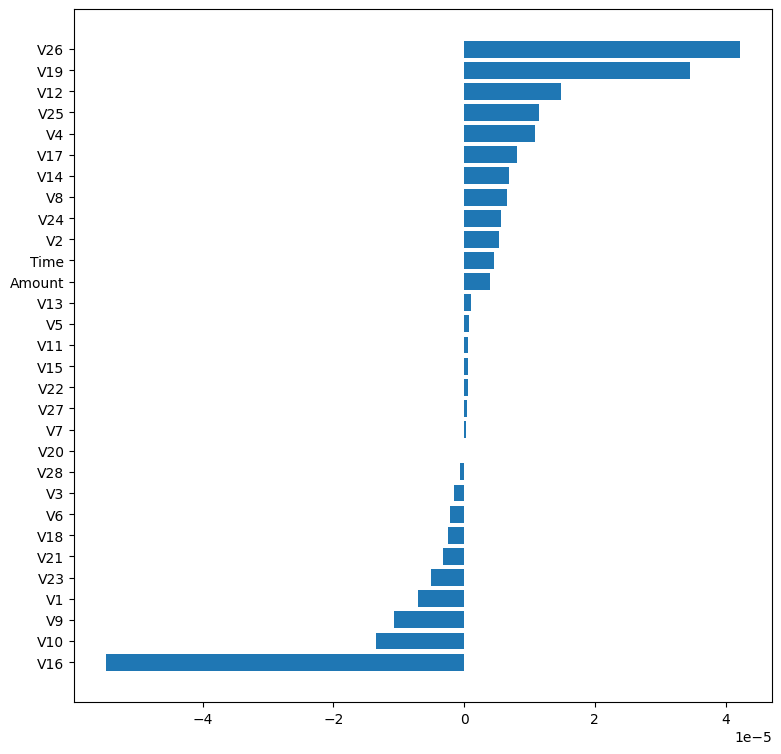

In [48]:
# Visualize the Feature Attributions
# Import necessary libraries for visualization.
import matplotlib.pyplot as plt
# Initialize lists to store features and their scores.
features = []
scores = []
# Extract feature attributions from the explanation.
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))] # Sort the features by their scores for better visualization.
scores = sorted(scores)
# Create a bar plot to visualize the feature attributions.
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

####  **Interpretation of the Bar Chart**
The Bar Chart above shows the feature attributions for a particular prediction made by the model. Here's a detailed interpretation of the chart:
- Horizontal Axis (Attribution Score) : The horizontal axis represents the attribution scores, which indicate the contribution of each feature to the model's prediction.
- Positive scores suggest that the feature contributes positively to the prediction (i.e., increasing the likelihood of the predicted class).
- Negative scores suggest that the feature contributes negatively to the prediction (i.e., decreasing the likelihood of the predicted class).
- The vertical axis lists the features from the dataset.
- Each bar corresponds to a feature and its length represents the magnitude of its attribution score.

**Example : (Your results could be different)**

**Top Contributing Features:**
- V26: The feature **V26** has the highest positive attribution score, indicating it is the most influential feature in driving the model's prediction towards the predicted class.
- V19 : Similarly, **V19** is also a significant positive contributor.

**Features with Lower Impact :**
-  Features like **V16** and **V10** have negative attribution scores, indicating they negatively impact the prediction. This means that higher values of these features reduce the likelihood of the predicted class.

**Neutral or Low-Impact Features :**
- Features closer to zero, such as **V7** and **V20**, have minimal impact on the prediction. They neither strongly support nor oppose the predicted outcome.

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
# this job would take +2 hours,  depending on your infrastcuture
# Create a batch prediction job to run predictions on a large dataset stored in BigQuery and save the results back to BigQuery.
# job_display_name: A descriptive name for the batch prediction job, useful for identifying it in the Vertex AI console.
# model_name : The name of the deployed model to be used for making predictions.
# instances_format : Specifies the format of the input data. Here, it is set to "bigquery" because the input data is in a BigQuery table.
# predictions_format : Specifies the format of the output predictions. Here, it is set to "bigquery" to store the predictions back in BigQuery.
# bigquery_source : The path to the BigQuery table that contains the input data.
# bigquery_destination_prefix : The project ID where the prediction results will be stored.
# generate_explanation : If set to True, the job will generate explanations for the predictions, providing insights into the model's decision-making process.
# labels :  Metadata labels for organizing and managing the job.

batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation=True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/292219499736/locations/us-central1/batchPredictionJobs/233030803628490752
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/292219499736/locations/us-central1/batchPredictionJobs/233030803628490752')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/233030803628490752?project=292219499736
